##Proyecto Weed-crop

In [ ]:
# Antes de empezar chequeo acceso al GPU
!nvidia-smi

# si esto no funciona hay que
# Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

Mon Mar 18 19:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Chequeo directorio
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Instalar YOLO Pip install method (recommended)
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
# librerias
import pandas as pd
import numpy as np
import torch

import shutil
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Descripción de los datos
Como datos para el entrenamiento tomamos de Kaggle el WeedCrop Image Dataset con 2822 imágenes de diferente calidad con formato YOLO v5 PyTorch.

Se aplicó el siguiente pre-procesamiento a cada imagen:

- Orientación automática de los datos de píxeles (con eliminación de la orientación EXIF).

Se aplicó el siguiente aumento para crear 3 versiones de cada imagen de origen:

- Probabilidad igual de una de las siguientes rotaciones de 90 grados: ninguna, en el sentido de las agujas del reloj, en sentido contrario a las agujas del reloj
- Giro aleatorio de entre -15° y +15° horizontalmente y -15° y +15° verticalmente
- Ajuste aleatorio de brillo entre -25 y +25

Clases: Cultivo, Maleza

Los datos estan divididos en train, validation y test.
- Train/entrenamiento contiene 2469 imágenes y sus respectivas etiquetas.
- Valid/validación contiene 235 imágenes y sus respectivas etiquetas.
- Test/prueba contiene 118 imágenes y sus respectivas etiquetas.

#Carga de datos desde el drive

In [ ]:
# Unir Colab con Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta principal del conjunto de datos en Google Drive
ruta_dataset = '/content/drive/MyDrive/Data_weed_crop'

# Obtener la lista de carpetas en el conjunto de datos (cada carpeta es una clase)
carpetas = os.listdir(ruta_dataset)
carpetas


['WeedCrop.v1i.yolov5pytorch']

# Estructuración y organizacion de imagenes en carpetas

Generamos una versión del conjunto de datos en la carpeta 'Working' esto mejora la robustez del modelo. La estructura de estos datos en entrenamiento, validación y testeo es la que se necesita para correr el modelo.

In [ ]:
source_folder = "/content/drive/MyDrive/Data_weed_crop/WeedCrop.v1i.yolov5pytorch"

In [ ]:
# Generamos una nueva version de los datos en una carpeta 'working'.
# carpeta train
train_source_images = os.path.join(source_folder, "train/images")
train_source_labels = os.path.join(source_folder, "train/labels")

train_destination_folder = "/content/working/train"
os.makedirs(train_destination_folder, exist_ok=True)

# copiar un directorio completo y su contenido de una ubicación a otra.
shutil.copytree(train_source_images, os.path.join(train_destination_folder, "images"))
shutil.copytree(train_source_labels, os.path.join(train_destination_folder, "labels"))

'/content/working/train/labels'

In [ ]:
# carpeta validación
valid_source_images = os.path.join(source_folder, "valid/images")
valid_source_labels = os.path.join(source_folder, "valid/labels")

valid_destination_folder = "/content/working/valid"
os.makedirs(valid_destination_folder, exist_ok=True)

# copiar un directorio completo y su contenido de una ubicación a otra.
shutil.copytree(valid_source_images, os.path.join(valid_destination_folder, "images"))
shutil.copytree(valid_source_labels, os.path.join(valid_destination_folder, "labels"))

'/content/working/valid/labels'

In [ ]:
# carpeta test
test_source_images = os.path.join(source_folder, "test/images")
test_source_labels = os.path.join(source_folder, "test/labels")

test_destination_folder = "/content/working/test"
os.makedirs(test_destination_folder, exist_ok=True)

# copiar un directorio completo y su contenido de una ubicación a otra.
shutil.copytree(test_source_images, os.path.join(test_destination_folder, "images"))
shutil.copytree(test_source_labels, os.path.join(test_destination_folder, "labels"))

'/content/working/test/labels'

In [ ]:
# Exportamos el conjunto de datos para cargarlo directamente en el colab y facilitar el entrenamiento.

def move_files(file_path, source_folder, destination_folder):
    # Lectura de una lista de nombres de archivo
    with open(file_path, "r") as file:
      # Extraer nombres de archivo basados en líneas y eliminar espacios en blanco
        file_names = [os.path.basename(line.strip()) for line in file.readlines()]

    # Define las carpetas de destino para imágenes y etiquetas
    images_folder = os.path.join(destination_folder, "images")
    labels_folder = os.path.join(destination_folder, "labels")

    # Traslado de archivos
    for file_name in file_names:
      # Ruta completa al archivo de imagen en la carpeta de origen
        image_file = os.path.join(source_folder, file_name)
      # Ruta completa al archivo de etiqueta en la carpeta de origen (reemplazando la extensión .png con .txt)
        label_file = os.path.join(source_folder, file_name.replace(".png", ".txt"))
      # Verificar si el archivo de imagen existe y copiarlo a la carpeta de imágenes de destino
        if os.path.isfile(image_file):
            shutil.copy(image_file, images_folder)
      # Verificar si el archivo de etiqueta existe y copiarlo a la carpeta de etiquetas de destino
        if os.path.isfile(label_file):
            shutil.copy(label_file, labels_folder)

# Mostrar ejemplo de imagenes

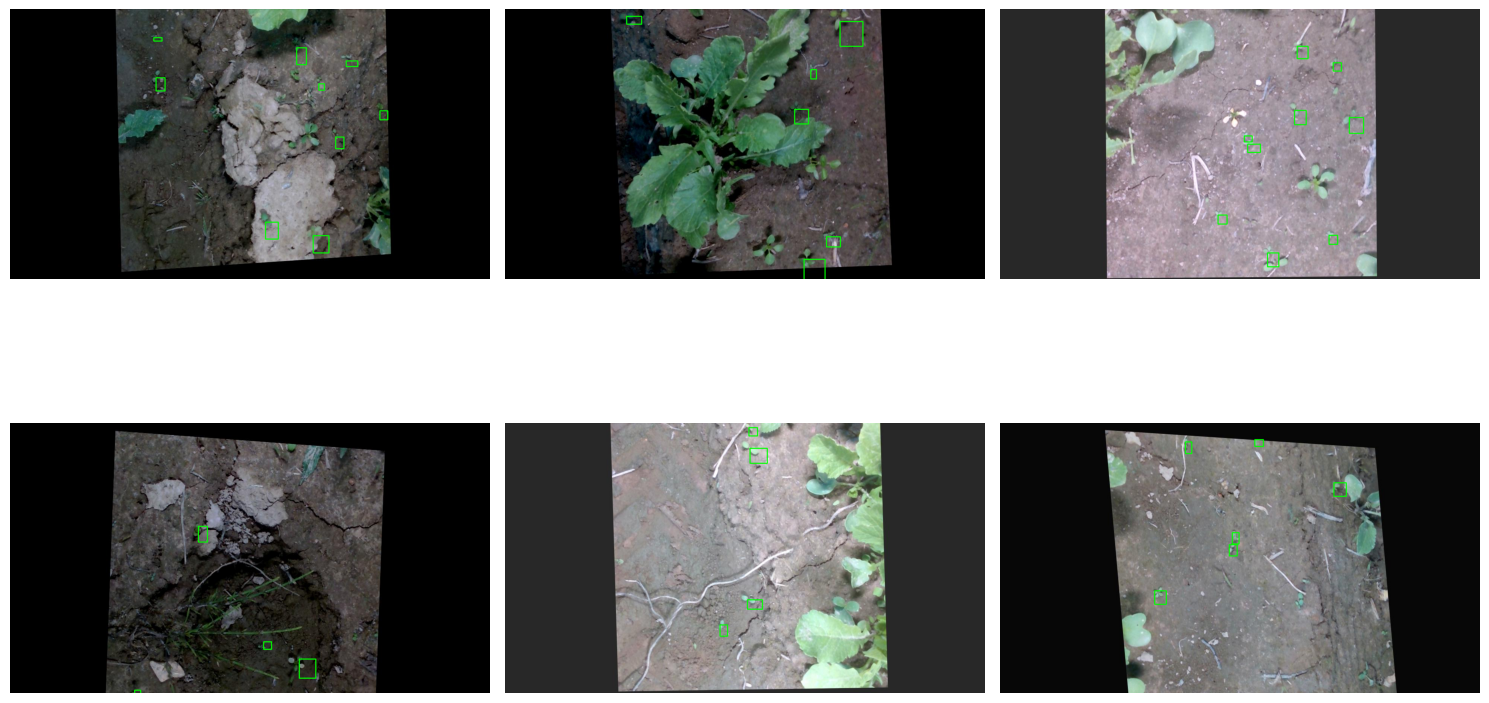

In [ ]:
# Carpetas con imágenes y etiquetas
images_folder = "/content/working/train/images"
labels_folder = "/content/working/train/labels"

# Cargar una lista de archivos de imagen
image_files = os.listdir(images_folder)

# Selección de imágenes aleatorias
random.shuffle(image_files)
random_image_files = image_files[:6]

# Mostrar imágenes etiquetadas aleatoriamente
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_images):
    # Cargar una imagen
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Carga de etiquetas desde un archivo
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Visualización de una imagen etiquetada
    for label in labels:
        class_id, x, y, width, height = map(float, label.strip().split())
        x = int(x * image.shape[1])
        y = int(y * image.shape[0])
        width = int(width * image.shape[1])
        height = int(height * image.shape[0])
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Visualización de la imagen
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Conjunto de datos en formato YAML

Ultralytics para entrenar modelos de detección utiliza el formato de archivo YAML para definir el conjunto de datos y la configuración del modelo.

In [ ]:
# Crear yaml para YOLO
import  yaml

# Data structure
dataset = {
'train': '/content/working/train',
'val': '/content/working/valid',
'test': '/content/working/test',
'nc': 2,
'names': ['crop', 'weed']
}

# save to YAML-file
with open('/content/working/dataset.yaml', 'w') as file:
    yaml.dump(dataset, file)

In [ ]:
!ls /content/working

dataset.yaml  test  train  valid


# Entrenamiento

In [ ]:
# Activo el GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Modelo en Yolo
# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 105MB/s]


In [ ]:
model.train(data='/content/working/dataset.yaml ', epochs=60, imgsz=640,
            optimizer = 'AdamW', lr0 = 1e-3,
            project = 'detect_WC', name='epoc60',
            batch=8, device=device, seed=69, save=True, plots=True)

# Results saved to detect_WC/epoc60

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/working/dataset.yaml , epochs=60, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=detect_WC, name=epoc60, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 25.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/working/train/labels... 2469 images, 101 backgrounds, 0 corrupt: 100%|██████████| 2469/2469 [00:02<00:00, 868.48it/s] 

train: New cache created: /content/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/working/valid/labels... 235 images, 0 backgrounds, 0 corrupt: 100%|██████████| 235/235 [00:00<00:00, 888.02it/s]

val: New cache created: /content/working/valid/labels.cache


Plotting labels to detect_WC/epoc60/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to detect_WC/epoc60
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      1.43G      2.728      2.544      1.301         21        640: 100%|██████████| 309/309 [01:25<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]

                   all        235       1605      0.249       0.29      0.218     0.0802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60       1.3G      2.596      2.233      1.235         33        640: 100%|██████████| 309/309 [01:17<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


                   all        235       1605       0.25      0.339      0.237      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       1.3G      2.531      2.135      1.216         39        640: 100%|██████████| 309/309 [01:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


                   all        235       1605      0.511      0.387      0.314      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      1.32G      2.479      2.064      1.198         48        640: 100%|██████████| 309/309 [01:11<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

                   all        235       1605      0.535      0.445      0.414      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      1.31G      2.412      2.013      1.175         22        640: 100%|██████████| 309/309 [01:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


                   all        235       1605      0.306      0.513      0.387      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       1.3G      2.393      1.978      1.165         89        640: 100%|██████████| 309/309 [01:12<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

                   all        235       1605       0.49       0.44      0.458        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      1.29G      2.335      1.894      1.145         75        640: 100%|██████████| 309/309 [01:11<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


                   all        235       1605      0.512      0.599      0.523      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60       1.3G      2.297      1.817      1.134         39        640: 100%|██████████| 309/309 [01:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]

                   all        235       1605      0.427      0.638      0.515      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      1.31G      2.264      1.776      1.118         45        640: 100%|██████████| 309/309 [01:11<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

                   all        235       1605      0.507        0.6      0.559      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60       1.3G      2.226      1.734       1.11         39        640: 100%|██████████| 309/309 [01:13<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]

                   all        235       1605      0.449      0.658      0.577      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60       1.3G      2.179      1.675      1.091         38        640: 100%|██████████| 309/309 [01:11<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]

                   all        235       1605       0.51      0.638      0.614      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      1.34G       2.19      1.665      1.095         61        640: 100%|██████████| 309/309 [01:11<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


                   all        235       1605      0.597      0.605      0.643      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60       1.3G      2.155       1.64      1.092         27        640: 100%|██████████| 309/309 [01:13<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]

                   all        235       1605      0.523      0.609      0.513      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      1.31G      2.145      1.595      1.083         12        640: 100%|██████████| 309/309 [01:13<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


                   all        235       1605      0.638      0.668       0.65      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60       1.3G      2.159      1.616      1.087         48        640: 100%|██████████| 309/309 [01:12<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


                   all        235       1605      0.464      0.671      0.515      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       1.3G      2.102      1.545      1.073         22        640: 100%|██████████| 309/309 [01:13<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


                   all        235       1605      0.686      0.649      0.697      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      1.32G      2.084      1.513      1.064         64        640: 100%|██████████| 309/309 [01:12<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


                   all        235       1605      0.596      0.689       0.67      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       1.3G      2.067      1.495      1.057         26        640: 100%|██████████| 309/309 [01:14<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

                   all        235       1605      0.548      0.615      0.624      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       1.3G       2.06      1.489      1.052         60        640: 100%|██████████| 309/309 [01:12<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


                   all        235       1605      0.551       0.63      0.578      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      1.34G      2.044      1.488      1.058         24        640: 100%|██████████| 309/309 [01:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

                   all        235       1605       0.65      0.638       0.63      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      1.32G      2.045      1.445      1.059         49        640: 100%|██████████| 309/309 [01:14<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


                   all        235       1605      0.672      0.681      0.694      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      1.32G      2.046      1.467      1.052         43        640: 100%|██████████| 309/309 [01:11<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]

                   all        235       1605      0.506      0.705       0.62      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      1.29G      2.019      1.441      1.053         28        640: 100%|██████████| 309/309 [01:16<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


                   all        235       1605      0.747      0.649       0.68      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       1.3G       2.01      1.398      1.046         25        640: 100%|██████████| 309/309 [01:13<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

                   all        235       1605      0.643      0.691      0.643      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60       1.3G      1.995      1.419       1.04         46        640: 100%|██████████| 309/309 [01:12<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


                   all        235       1605      0.656      0.657      0.678      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      1.32G      1.999      1.407      1.046         16        640: 100%|██████████| 309/309 [01:16<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]

                   all        235       1605       0.63      0.664      0.671      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       1.3G      1.986       1.38      1.044         25        640: 100%|██████████| 309/309 [01:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


                   all        235       1605      0.613      0.638      0.619      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       1.3G      1.957      1.361       1.03         48        640: 100%|██████████| 309/309 [01:16<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


                   all        235       1605      0.568      0.715      0.626      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      1.31G      1.947       1.35      1.028         40        640: 100%|██████████| 309/309 [01:12<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]

                   all        235       1605      0.561      0.616      0.612      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60       1.3G      1.948      1.349      1.033         36        640: 100%|██████████| 309/309 [01:12<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


                   all        235       1605      0.678      0.697      0.719      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      1.29G      1.928      1.336       1.03         57        640: 100%|██████████| 309/309 [01:14<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]

                   all        235       1605      0.662      0.734      0.711      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60       1.3G      1.894      1.292      1.016         21        640: 100%|██████████| 309/309 [01:12<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


                   all        235       1605      0.662      0.718        0.7      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      1.31G      1.913      1.331      1.024         29        640: 100%|██████████| 309/309 [01:13<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]

                   all        235       1605      0.682      0.747      0.701      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      1.34G      1.903      1.294      1.021         45        640: 100%|██████████| 309/309 [01:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

                   all        235       1605      0.629      0.708      0.707      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60       1.3G      1.908       1.31      1.027         40        640: 100%|██████████| 309/309 [01:12<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]

                   all        235       1605      0.696       0.69       0.71      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      1.32G      1.876      1.273      1.018         49        640: 100%|██████████| 309/309 [01:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


                   all        235       1605      0.694      0.697      0.691      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       1.3G      1.853      1.263      1.007         26        640: 100%|██████████| 309/309 [01:12<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]

                   all        235       1605      0.738       0.69      0.722      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      1.31G      1.852      1.249      1.007         45        640: 100%|██████████| 309/309 [01:14<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


                   all        235       1605      0.702      0.679      0.711      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      1.29G      1.845      1.255      1.011         40        640: 100%|██████████| 309/309 [01:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


                   all        235       1605      0.656      0.741      0.717      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       1.3G      1.822      1.227      1.002         43        640: 100%|██████████| 309/309 [01:12<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

                   all        235       1605      0.718       0.71      0.717      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      1.31G      1.835      1.236      1.002         38        640: 100%|██████████| 309/309 [01:14<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]

                   all        235       1605      0.735      0.743      0.753      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      1.33G      1.798      1.215     0.9953         37        640: 100%|██████████| 309/309 [01:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]

                   all        235       1605      0.731      0.723      0.747      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      1.31G      1.826      1.222      1.004         48        640: 100%|██████████| 309/309 [01:14<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


                   all        235       1605      0.788      0.713      0.762       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       1.3G      1.819      1.218      1.005         27        640: 100%|██████████| 309/309 [01:12<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]

                   all        235       1605      0.782      0.741      0.764      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60       1.3G      1.826       1.21      1.001         39        640: 100%|██████████| 309/309 [01:12<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]

                   all        235       1605      0.721      0.723      0.743      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       1.3G       1.78      1.208     0.9994         69        640: 100%|██████████| 309/309 [01:14<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


                   all        235       1605      0.705      0.774      0.724      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      1.29G       1.79      1.185     0.9949         58        640: 100%|██████████| 309/309 [01:13<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]

                   all        235       1605      0.751      0.727       0.75      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       1.3G      1.787      1.185     0.9954         66        640: 100%|██████████| 309/309 [01:14<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

                   all        235       1605      0.723      0.729      0.762      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       1.3G      1.768      1.169      0.992         54        640: 100%|██████████| 309/309 [01:11<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


                   all        235       1605      0.695      0.757      0.734      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      1.32G       1.74      1.155     0.9825         45        640: 100%|██████████| 309/309 [01:12<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        235       1605       0.69      0.734      0.716      0.387


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      1.41G      1.756       1.19      1.023         48        640:   5%|▍         | 14/309 [00:04<00:49,  5.97it/s]

In [ ]:
# Guardo los resultados del entrenamiento en el drive
# Results saved to detect_WC/e70

from distutils.dir_util import copy_tree

source_folder = '/content/detect_WC/epoc60'
destination_folder = '/content/drive/MyDrive/Resultados_detect_WC_epoc60'

# Asegúrate de que la carpeta de destino exista, si no, créala
os.makedirs(destination_folder, exist_ok=True)

# Copiar todo el contenido de la carpeta fuente a la carpeta destino
copy_tree(source_folder, destination_folder)

In [ ]:
# si tengo que reanudar un entrenamiento interrumpido

# Load a model
#model = YOLO('path/to/last.pt')  # load a partially trained model

# Resume training
#results = model.train(resume=True)

# Métricas del entrenamiento y pérdidas


In [ ]:
#image_folder ='/content/drive/MyDrive/Resultados_detect_WC_e50'
image_folder = "/content/detect_WC/epoc60"

image_filenames = [
    "results.png",
    "confusion_matrix.png",
    "P_curve.png",
    "F1_curve.png",
    "R_curve.png",
    "PR_curve.png",
    "labels.jpg",
    "val_batch1_labels.jpg",
    "val_batch1_pred.jpg"
]

for filename in image_filenames:
    print("###\t"+filename+"\t###\n")
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)
    display(image)

# Análisis de resultados del entrenamiento
Los resultados de Box_loss, Cls_loss y dfl_loss presentan curvas descendentes lo que indica que el modelo aprende correctamente a localizar, clasificar los objetos en las imagenes, y a evitar falsas detecciones.  

In [ ]:
# confusion matrix
confusion_matrix = Image.open("/content/detect_WC/epoc60/confusion_matrix.png")
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.axis("off")
plt.show()

# Arreglar
El mayor número de errores de nuestro modelo se debió a la clasificación errónea de objetos como "fondo" cuando en realidad eran malas hierbas: 602 errores de este tipo. A la inversa, se produjeron 965 errores cuando el modelo clasificó las malas hierbas como "fondo".

En otros casos, el número de errores fue insignificante, en torno a los valores 10-12.

# Validación

Una vez finalizado el entrenamiento, es una buena práctica validar el nuevo modelo con imágenes que no haya visto antes. Esto nos permite evaluar la calidad del modelo entrenado que se guarda en la carpeta runs/detect/train/weights/best.pt.

In [ ]:
# Modelo entrenado
model1  = YOLO('/content/detect_WC/epoc60/weights/best.pt')

In [ ]:
# Validación del modelo
metrics = model1.val()

#Results saved to runs/detect/val

#Métricas de la validacion/performance del modelo

In [ ]:
#  Validate the model,evaluate the model's performance on the valid dataset
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

In [ ]:
# Gráficos con las métricas
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

ax.set_title('Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

fig = plt.gcf()
fig.set_size_inches(8, 6)

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

In [ ]:
# Recuperación de los valores Precision, Recall y F1
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
f1 = (2 * precision * recall) / (precision + recall)
metrics = ['Precision', 'Recall', 'F1']
values = [precision, recall, f1]

# Creación de un gráfico con sns.barplot
ax = sns.barplot(x=metrics, y=values, palette='viridis')

ax.set_title('Precision, Recall, and F1 Scores')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

Veamos 10 imagenes aleatorias

In [ ]:
#Obtención de imágenes aleatorias
image_paths = random.sample(os.listdir(images_folder), 10)

# Creación de una figura con subventanas y ampliación del tamaño de la foto
fig, axes = plt.subplots(5, 2, figsize=(50, 40))
fig.tight_layout()

# Iterar sobre cada subventana
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(images_folder, image_paths[i])
    image = Image.open(image_path)
    res = model1(image, verbose=False)
    detect_img = res[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    ax.imshow(detect_img)
    ax.axis('off')

plt.show()

Así, el modelo muestra una mayor precisión en la detección de objetos con umbrales de confianza más bajos, mientras que con umbrales más altos su precisión disminuye. Esto puede deberse a que, con umbrales de confianza altos, el modelo se vuelve más conservador y pasa por alto algunos objetos para reducir la probabilidad de falsos positivos.

Como se puede ver en las métricas, la "Precisión" del modelo es bastante buena, reconoce bien ambas clases y las encuentra más o menos con la misma puntuación.



# Inferencia

Aca usamos los datos nunca vistos de la carpeta test para hacer predicciones.

In [ ]:
# modelo entrenado
model1  = YOLO('/content/detect_WC/e70/weights/best.pt')

# Predicciones con el modelo en el dataset test
#results = model1.predict(source="/content/working/test/images", save=True)
model1.predict(source="/content/working/test/images", save=True)

In [ ]:
# Verify the validation results saved to runs/detect/predict
# Results saved to runs/detect/predict
directory = 'runs/detect/predict'
image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
random_images = random.sample(image_files,10)
for image in random_images:
    image_path = os.path.join(directory, image)
    image = Image.open(image_path)
    display(image)

In [ ]:
# veo 10 imagenes del dataset test con las predicciones del modelo
directory = 'runs/detect/predict'
image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
random_images = random.sample(image_files,10)
for image in random_images:
    image_path = os.path.join(directory, image)
    image = Image.open(image_path)
    display(image)

In [ ]:
# Obtención de imágenes aleatorias
image_paths = random.sample(os.listdir(images_folder), 10)

# Creación de una figura con subventanas y ampliación del tamaño de la foto
fig, axes = plt.subplots(8, 1, figsize=(50, 40))
fig.tight_layout()

# Iterar sobre cada subventana
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(images_folder, image_paths[i])
    image = Image.open(image_path)
    res = model1(image, verbose=False)
    detect_img = res[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    ax.imshow(detect_img)
    ax.axis('off')

plt.show()

In [ ]:
# Exportamos el modelo
# Load a model
model  = YOLO('/content/detect_WC/e70/weights/best.pt')

# Export the model
model.export(format='onnx', dynamic=True)

# Conclusión le falta!

En este cuaderno, entrenamos el modelo YOLOv8x en datos agrupados, estudiamos las métricas y las pérdidas durante el entrenamiento, y analizamos el resultado del modelo en múltiples imágenes y la calidad de la detección en datos de prueba.

Se recomienda seguir investigando para lograr un mejor rendimiento del modelo y aplicarlo con éxito a los procesos empresariales. He aquí algunas medidas que pueden adoptarse:

Recopilar más datos: Una mayor cantidad y variedad de datos ayudará al modelo a generalizar y reconocer mejor los objetos. Se pueden recopilar nuevos datos o encontrar conjuntos de datos disponibles para complementar el conjunto de entrenamiento actual.

Personalizar los hiperparámetros: La selección de los hiperparámetros óptimos del modelo puede afectar significativamente a su rendimiento. Se puede experimentar con distintos valores de hiperparámetros, como tamaños de ancla, umbrales de confianza y otros, para lograr mejores resultados.

Realizar experimentos adicionales: Experimentar con diferentes arquitecturas del modelo, variaciones de YOLOv8 u otros modelos de detección de objetos, puede conducir a mejores resultados.

Etc.

En general, una investigación más precisa (en particular, se necesitan más datos etiquetados con etiquetas y cajas de maleza), la experimentación y el trabajo en la mejora del modelo conducirán a un mejor rendimiento y aumentarán su aplicabilidad en escenarios empresariales reales. Por supuesto, todo depende de los recursos, tanto computacionales como monetarios.